In [1]:
import numpy as np
import scipy as sp
import matplotlib as mp
from matplotlib import pyplot as plt
import skimage as ski
from scipy.fft import fft, fftfreq, ifft, rfft, fftshift
import scipy.signal.windows as wind
import os

In [2]:
path, file = "C:/Users/User/Pictures/Aspa", input("Введите имя файла с указанием формата: ")
filename = os.path.join(path, file)
signal = ski.io.imread(filename)

Введите имя файла с указанием формата: Sig0.png


In [3]:
pixcolor = []
rgb = ["r", "g", "b"]
print("Введите цвет линии в формате rgb \n")
for j in range(3):
    pixcolor.append(int(input(rgb[j]+" : ")))

Введите цвет линии в формате rgb 

r : 255
g : 255
b : 0


## Создаем массив масок по каждому столбцу пикселей

Сканируем изображение в следующем порядке: сверху вниз, слева направо, начиная с верхнего левого пикселя. 
В результате для каждого вертикального столбца пикселей получим "маску" - массив булевских значений, каждое из значений которого соответствует одному пикселю начинае сверху. Если цвет равен целевому - ставется true, иначе false.

In [4]:
masks = np.array([[0 for j in range(signal.shape[1])] for i in range(signal.shape[0])], dtype = 'bool')
for j in range(signal.shape[1]):
    for i in range(signal.shape[0]):
        masks[i][j] = (signal[i][j][0] == pixcolor[0] and signal[i][j][1] == pixcolor[1] and signal[i][j][2] == pixcolor[2])

## Переводим маски в числа

Для каждой маски находим координаты всех истинных значений. Если значений больше одного - берём среднее арифметическое.
Все nan заменяем на 0.

In [5]:
rows = np.arange(signal.shape[0])
sig_dig = np.zeros(signal.shape[1])
for j in range(signal.shape[1]):
    mask = masks[:,j]
    sig_dig[j] = (signal.shape[0] - np.ceil(np.mean(rows[mask])) - np.floor(signal.shape[0] / 2)) / (signal.shape[0]) * 2
sig_dig[np.isnan(sig_dig)] = 0

In [92]:
np.arange(0, signal.shape[0],50)

19

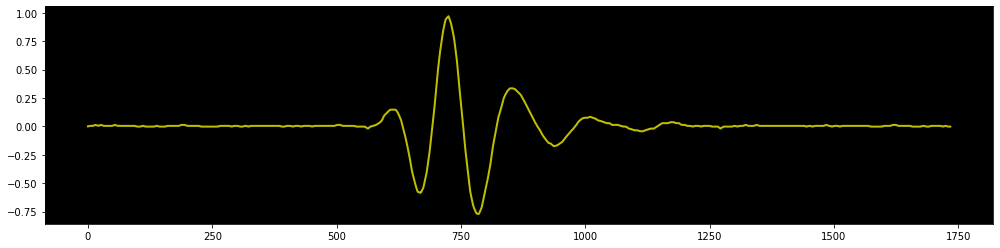

In [6]:
plt.figure(figsize = (17, 4))
plt.plot(sig_dig, color = 'y', linewidth = 2)
ax = plt.gca() 
#ax.set_xticks(np.arange(0, signal.size, 50))
ax.set_facecolor("black")
plt.show()

In [60]:
zero_mask = np.abs(sig_dig) <= 0.01 * np.max(sig_dig)
zero_mask[450:1000] = False
zero_mask[1000:] = True
sig_dig[zero_mask] = 0

In [14]:
zero_mask

array([False, False, False, ..., False, False, False])

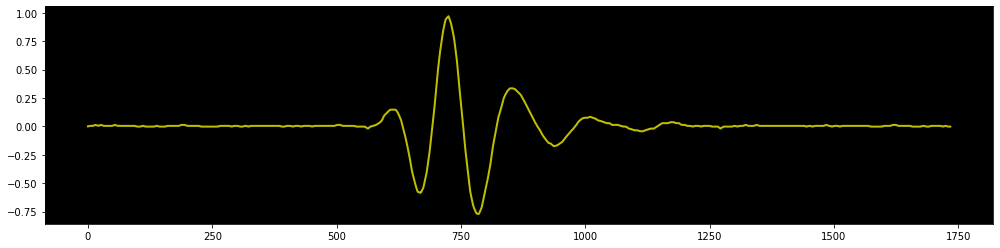

In [7]:
plt.figure(figsize = (17, 4))
plt.plot(sig_dig, color = 'y', linewidth = 2)
ax = plt.gca() 
#ax.set_xticks(np.arange(0, signal.size, 50))
ax.set_facecolor("black")
plt.show()

In [8]:
N = signal.shape[1]
matrix = np.array([[0 for k in range(N)] for i in range(5)], dtype = 'float64')
t_matrix = np.array([[0 for k in range(N)] for i in range(5)], dtype = 'float64')

In [9]:
x_min = 41.65
x_max = 50.8
delta_x = x_max - x_min
c = 1.8e-6
t_max = delta_x * c
t = np.linspace(- t_max / 2, t_max / 2, N)
delta_t = np.abs(t[1] - t[0])

In [10]:
line_c = 899 #Координата линии отсечки
signal2 = sig_dig 
#spectrum = fft_manual2(signal2)
spectrum = fftshift(fft(fftshift(signal2))) / N - 0.00024
spect_f = fftfreq(N, delta_t) * 2 * np.pi

matrix[0,:] = signal2
t_matrix[0,:] = t
matrix[1,:] = np.abs(spectrum)
t_matrix[1,:] = fftshift(spect_f)
#matrix[2,:] = np.angle(spectrum)

matrix[3,:] = np.real(spectrum)
matrix[3, line_c:] = 0.00001
t_matrix[3,:] = fftshift(spect_f)
matrix[4,:] = np.imag(spectrum)
t_matrix[4,:] = fftshift(spect_f)
matrix[4, line_c:] = 0

matrix[2,:] = np.arctan(matrix[4,:] / matrix[3,:])
t_matrix[2,:] = fftshift(spect_f)

In [96]:
N / 2

869.0

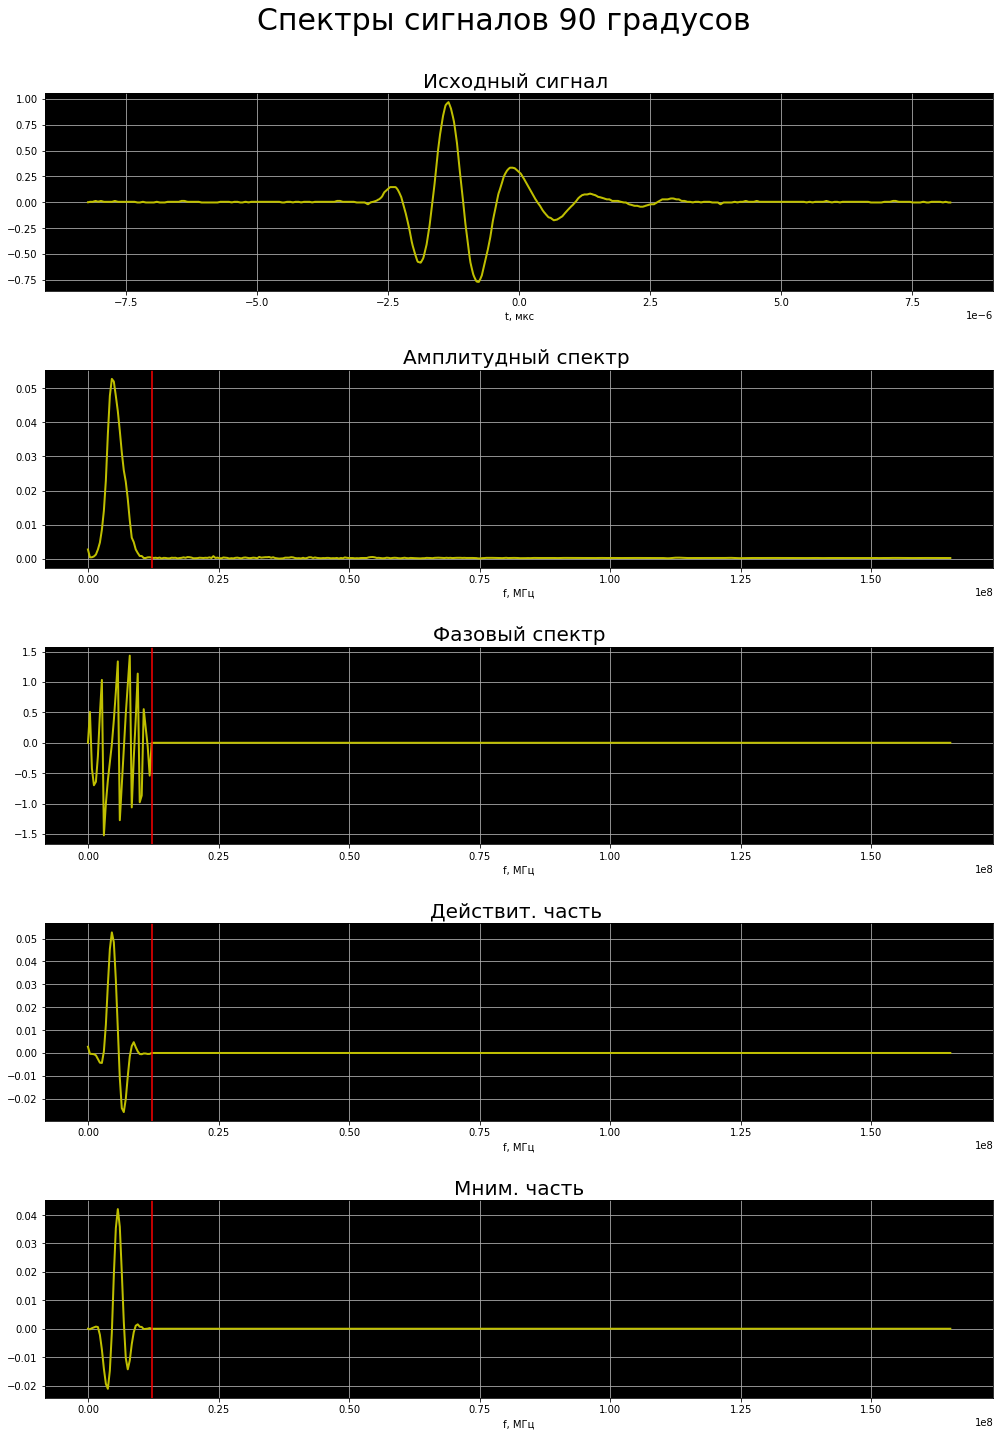

In [11]:
fig, axs = plt.subplots(5, 1, figsize = (17, 24))

fig.suptitle("Спектры сигналов 90 градусов", y = 0.93, fontsize = 30)
plt.subplots_adjust(hspace=0.4)
Na = N / 4 #Размер окна для спектра

axs[0].plot(t_matrix[0,:], matrix[0,:], color = 'y', linewidth = 2)
axs[0].set_title("Исходный сигнал ", fontsize = 20)
#axs[0].set_xticks(np.arange(min(t), max(t), 5))
axs[0].set_xlabel("t, мкс", loc = 'center')
#axs[0].set_ylim(-1.0, 1.0)
axs[0].set_facecolor("black")
axs[0].grid('on')

axs[1].plot(t_matrix[1,int(N /2) : int(N /2 + Na)], matrix[1,int(N /2) : int(N /2 + Na)], color = 'y', linewidth = 2)
axs[1].set_title("Амплитудный спектр ", fontsize = 20)
axs[1].set_xlabel("f, МГц", loc = 'center')
axs[1].set_facecolor("black")
#axs[1].axvline(t_matrix[1,line_c], color = 'red')
axs[1].grid('on')

axs[2].plot(t_matrix[2,int(N /2) : int(N /2 + Na)], matrix[2,int(N /2) : int(N /2 + Na)], color = 'y', linewidth = 2)
axs[2].set_title("Фазовый спектр", fontsize = 20)
axs[2].set_xlabel("f, МГц", loc = 'center')
axs[2].set_facecolor("black")
axs[2].axvline(t_matrix[2,line_c], color = 'red')
axs[2].grid('on')

axs[3].plot(t_matrix[3,int(N /2) : int(N /2 + Na)], matrix[3,int(N /2) : int(N /2 + Na)], color = 'y', linewidth = 2)
axs[3].set_title("Действит. часть ", fontsize = 20)
axs[3].set_xlabel("f, МГц", loc = 'center')
axs[3].set_facecolor("black")
axs[3].axvline(t_matrix[3,line_c], color = 'red')
axs[3].grid('on')

axs[4].plot(t_matrix[4,int(N /2) : int(N /2 + Na)], matrix[4,int(N /2) : int(N /2 + Na)], color = 'y', linewidth = 2)
axs[4].set_title("Мним. часть", fontsize = 20)
axs[4].set_xlabel("f, МГц", loc = 'center')
axs[4].set_facecolor("black")
axs[4].axvline(t_matrix[4,line_c], color = 'red')
axs[4].grid('on')

In [33]:
t

array([-3.64615385e-06, -3.64222903e-06, -3.63830421e-06, ...,
        3.63830421e-06,  3.64222903e-06,  3.64615385e-06])

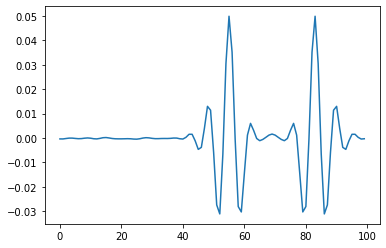

In [92]:
plt.plot(matrix[3,800:900])